# Sentiment Analysis with Hugging Face

This project aims to find out the public sentiment on covid-19 vaccination by using a fine-tuned, pre-trained, RoBERTa-base model to analyze covid-19 vaccination tweets.

# Installations and Setup

In [1]:
# Installations

!pip install datasets
!pip install contractions
!pip install transformers
!pip install -q transformers datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0

In [2]:
# Importations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from google.colab import drive
from datasets import load_dataset
from datasets import load_metric

import contractions
from wordcloud import WordCloud
from collections import Counter
import re

from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoConfig, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from huggingface_hub import notebook_login

The "Weights & Biases" (wandb) platform will be disabled to avoid unnecessary interactions with external services.

In the context of machine learning and data science workflows, "Weights & Biases" is a platform that helps to track and visualize machine learning experiments. It provides tools for logging various metrics, visualizing training progress, and comparing different experiments.

The "Weights & Biases" (wandb) platform can also be disabled if using a different experiment tracking tool is preferred.

In [3]:
# Disabe W&B

os.environ['WANDB_DISABLED'] = 'true'

In [4]:
# Login to huggingface

notebook_login()

# Data Exploration

In [5]:
# Mount Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the directory path within the Google Drive
drive_path = '/content/drive/MyDrive/Google Colab/NLP/'

# Define the file name
file_name = 'Train.csv'

# Combine the directory and file name to create the full file path
file_path = drive_path + file_name

In [7]:
# Load the dataset and display some values

df = pd.read_csv(file_path)
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [8]:
# Check the shape of the dataset

df.shape

(10001, 4)

In [9]:
# Check the datatype of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [10]:
# Check for missing values

df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

As can be seen, the label column has a row with missing value while the agreement column has two rows with missing values. Since there are few rows with missing values, the rows will be dropped.

In [11]:
# Eliminate rows containing missing values

df = df[~df.isna().any(axis=1)]

In [12]:
# Confirm that the rows with missing values have been eliminated

df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [13]:
# Check for duplicates

df.duplicated().sum()

0

There are no duplicates in the dataset.

In [14]:
# Check the text in the safe_text column

text = df['safe_text']
text

0        Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1        I'm 100% thinking of devoting my career to pro...
2        #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3        I mean if they immunize my kid with something ...
4        Thanks to <user> Catch me performing at La Nui...
                               ...                        
9996     Living in a time where the sperm I used to was...
9997     <user> <user>  In spite of all measles outbrea...
9998     Interesting trends in child immunization in Ok...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine: for women w risk of pulmona...
Name: safe_text, Length: 9999, dtype: object

In [15]:
# Change the datatype of the safe_text column to string

df['safe_text'] = df['safe_text'].astype(str)

<ipython-input-15-70c238b7bd96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['safe_text'] = df['safe_text'].astype(str)


In [16]:
# Remove '<user>' , '<url>', 'user', 'url' from the safe_text column
strings_to_replace = ['<user>', '<url>', 'user', 'url'] # Define a list of strings to remove

# Iterate through the list and replace each string with an empty string
for string in strings_to_replace:
    df['safe_text'] = df['safe_text'].str.replace(string, '')

<ipython-input-16-7acc6aeab723>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['safe_text'] = df['safe_text'].str.replace(string, '')


In [17]:
# Remove leading (left) whitespace characters in the safe_text column

df['safe_text'] = df['safe_text'].apply(lambda x: x.lstrip())
df['safe_text']

<ipython-input-17-dd6339ebc05f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['safe_text'] = df['safe_text'].apply(lambda x: x.lstrip())


0        Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1        I'm 100% thinking of devoting my career to pro...
2        #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3        I mean if they immunize my kid with something ...
4        Thanks to  Catch me performing at La Nuit NYC ...
                               ...                        
9996     Living in a time where the sperm I used to was...
9997     In spite of all measles outbreaks, judge in MI...
9998     Interesting trends in child immunization in Ok...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine: for women w risk of pulmona...
Name: safe_text, Length: 9999, dtype: object

In [18]:
# Replace shortened forms of words (contractions) with their full forms in the safe_text column

df['safe_text'] = df['safe_text'].apply(lambda x: contractions.fix(x))
df['safe_text']

0        Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1        I am 100% thinking of devoting my career to pr...
2        #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3        I mean if they immunize my kid with something ...
4        Thanks to  Catch me performing at La Nuit NYC ...
                               ...                        
9996     Living in a time where the sperm I used to was...
9997     In spite of all measles outbreaks, judge in MI...
9998     Interesting trends in child immunization in Ok...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine: for women w risk of pulmona...
Name: safe_text, Length: 9999, dtype: object

# Data Visualization

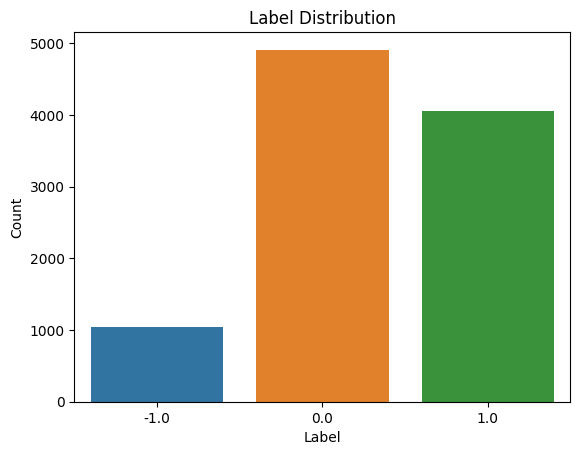

In [19]:
# Plot label distribution

sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The label distribution plotted above is a fundamental step in data exploration and understanding as it helps to identify whether the dataset is balanced or not. It helps analysts make informed data preprocessing decisions such as dataset balancing by oversampling the minority class, undersampling the majority class, or using more advanced techniques like Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset. Label distribution also influences model selection as some models perform better or worse depending on the balance of sentiment labels in the data. Also, label distribution influences the choice of performance evaluation metric. While accuracy might be a suitable performance metric for a dataset that has a balanced label distribution, plotting the label distribution will help identify if precision, recall, F1-score, or AUC-ROC should be considered.

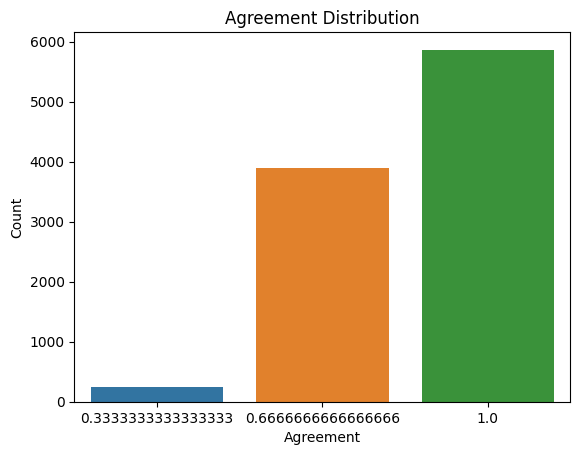

In [20]:
# Plot agreement distribution

sns.countplot(x='agreement', data=df)
plt.title('Agreement Distribution')
plt.xlabel('Agreement')
plt.ylabel('Count')
plt.show()

The agreement distribution plotted above is very useful in understanding and working with sentiment-labeled datasets. It helps ensure the quality of the data, provides insights into the nature of the sentiment analysis task, and informs decisions related to model training and evaluation.

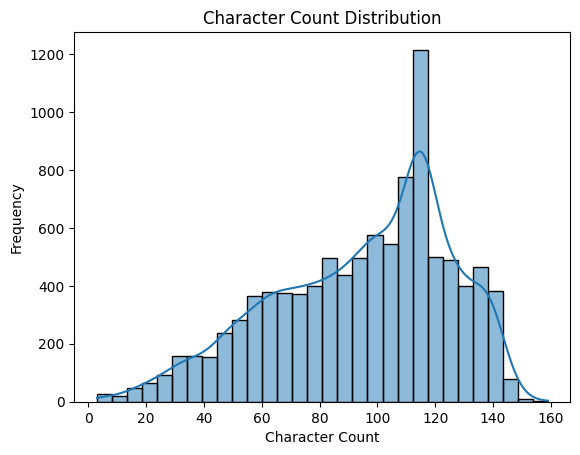

In [21]:
# Plot character count distribution to show the frequency of the number of characters on the tweets

df['character_count'] = df['safe_text'].apply(len) # Create 'character_count' column
sns.histplot(data=df, x='character_count', bins=30, kde=True)
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()
df.drop('character_count', axis=1, inplace=True) # Remove 'character_count' column

The character count distribution plotted above is a valuable visualization that helps analysts understand the nature of their data. It enables analysts to make informed preprocessing decisions (example performing text truncation or summarization techniques to manage long texts), and potentially extract useful features for the sentiment analysis model.  The character count distribution provides a clear picture of the data's characteristics and can be used in reports or presentations to illustrate the diversity of text lengths in the dataset as well as identify outliers or anomalies.

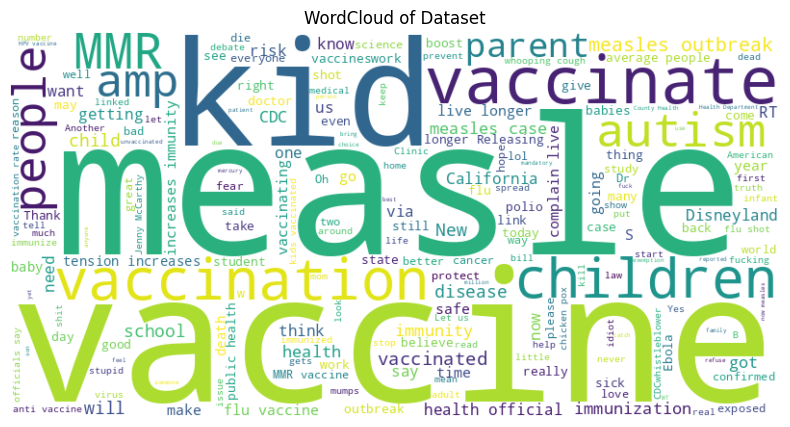

In [22]:
# Visualize wordcloud for the text in "safe_text" column

all_text = ' '.join(df['safe_text']) # Combine all text data into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text) # Describe wordcloud features

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Dataset')
plt.axis('off')
plt.show()

Word clouds are a useful visualization tool in sentiment analysis because they condense textual data into a visually digestible format, helping analysts and stakeholders gain insights into sentiment patterns and key terms within the text. It also helps to spot common stopwords (like "the", "and", "in") or irrelevant terms that will be removed during data preprocessing. In this usage, words like "user" and "url" have been spotted and will be removed.

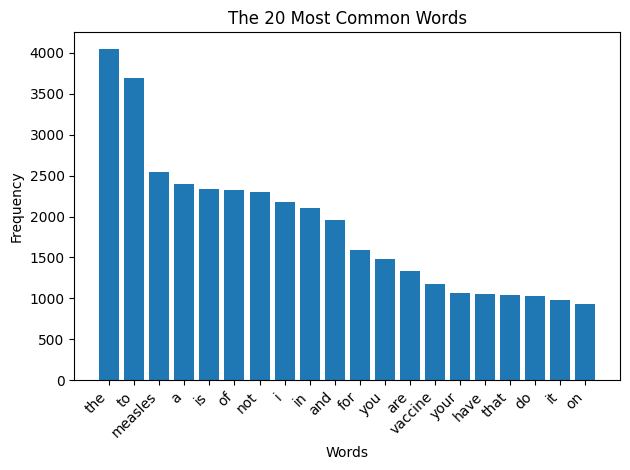

In [23]:
# Get the 20 most common words in 'safe_text' column
words = ' '.join(df['safe_text']).split()

# Convert all words to lowercase to make the word count case-insensitive
words = [word.lower() for word in words]

# Count word frequencies
word_frequency = Counter(words)

# Get the 20 most common words
most_common_words = word_frequency.most_common(20)

# Extract the words and their frequencies
top_words, top_frequencies = zip(*most_common_words)

# Create a bar plot to visualize the 20 most common words
plt.bar(top_words, top_frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('The 20 Most Common Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The plot above of the 20 most common words in the dataset provides a quick overview of the most frequently occurring words in the text data. Examining common words can reveal how sentiments are expressed in the dataset. For example, words like "happy," "good," or "positive" being among the common words show positive sentiment while words like "sad," "bad," or "negative" being among the common words show negative sentiment. The plot of the 20 most common words in the dataset can guide preprocessing decisions such as stemming, lemmatization, or handling of special characters, depending on the nature of the common words and their relevance to sentiment analysis.

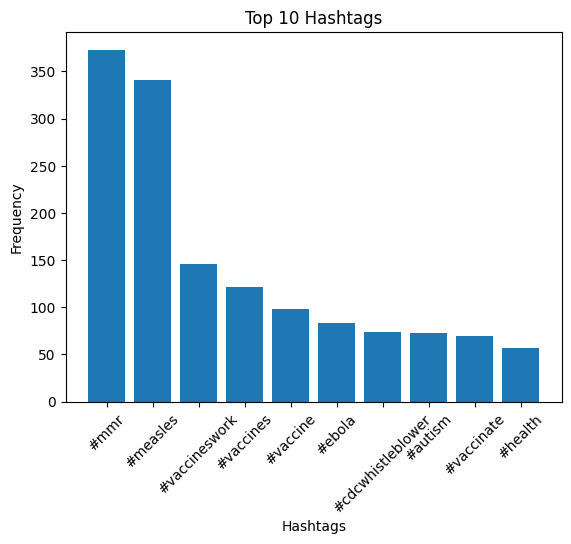

In [24]:
# Get the top 10 hashtags in 'safe_text' column
hashtags = re.findall(r'#\w+', all_text) # Use regular expression to find all hashtags

# Convert each hashtag to lowercase to make the hashtag count case-insensitive
hashtags = [tag.lower() for tag in hashtags]

# Count hashtag frequencies
hashtag_frequency = Counter(hashtags)

# Get the top 10 hashtags
top_10_hashtags = dict(hashtag_frequency.most_common(10))

# Plot the top 10 hashtags
plt.bar(top_10_hashtags.keys(), top_10_hashtags.values())
plt.title('Top 10 Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The top 10 hashtags shown above identifies the most common topics or themes in the text data. The plot helps in understanding the context in which texts are used, identifying key themes or subjects, public opinions and common trends that are driving sentiment. This information can be valuable for decision-making, content categorization, staying attuned to public opinion and explanation of findings to stakeholders.

# Data Transformation

### Splitting the dataset

I manually split the training set to have a training subset (a dataset the model will learn on), and an evaluation subset (a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one).

There are multiple ways to split the dataset. Another method will be shown in a cell whose codes are commented out, down below.

In [25]:
# Split the train data => {train, eval}

train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [26]:
# Display the first five rows of the train subset

train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,your ignorance on vaccines is not just dangero...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I have gone up like 1000 mmr,0.0,1.000000


In [27]:
# Display the first five rows of the evaluation subset

eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,no. I was properly immunized prior to the perf...,1.0,1.000000
3325,ESEVBTFN,thanks for posting vaccinations are imperative...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [28]:
# Display the shapes of the training and evaluation subsets

print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [29]:
# Define csv file names for the splitted subsets
train_subset = ('train_subset.csv')
eval_subset = ('eval_subset.csv')

# Define file paths to the Google Drive for the splitted subsets
train_file_path = drive_path + train_subset
eval_file_path = drive_path + eval_subset

# Save the splitted subsets to the Google Drive through their file paths
train.to_csv(train_file_path, index=False)
eval.to_csv(eval_file_path, index=False)

In [30]:
# Load the subsets into a dataset and encode the dataset using Latin-1 ("ISO-8859-1") encoding
# Latin-1 ("ISO-8859-1") encoding is used to read the text data in the dataset

dataset = load_dataset('csv',
                        data_files={'train': train_file_path,
                        'eval': eval_file_path}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

# Tokenization

Tokenization in Natural Language Processing (NLP) is the process of breaking down a sequence of text, such as a sentence or a paragraph, into individual units called tokens. Tokens are the fundamental building blocks used in text analysis, and they typically correspond to words or subwords.

Tokenization starts with a piece of text, which could be a sentence, a paragraph, or even an entire document.

The text is divided into smaller units known as tokens. These tokens can be words, subwords, or characters, depending on the granularity of the tokenization process.

Tokenization is a foundational step in many NLP tasks, including text classification, machine translation, sentiment analysis, and more. It transforms raw text data into a format that can be understood and processed by algorithms and models, facilitating various text analysis tasks.

In [31]:
# Create tokenizer object using AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [32]:
# Function to perform tokenization and padding
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Perform tokenization and padding on the tweets so that the models can be utilized
dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [33]:
# Function to transform the labels to fit the configuration of our pre-trained HuggingFace models
def transform_labels(label):
    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2
    return {'labels': num}

# Transform the	labels and remove unnecessary columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
# Display the dataset features

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [35]:
# Display the features of the train subset

dataset['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 7999
})

# Model Loading

In [36]:
# Load Roberta model and specify the number of labels in the dataset for fine-tuning

model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Fine-tuning

In [37]:
# Configure the training arguments

training_args = TrainingArguments(
    output_dir=drive_path + "results",
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=2000,
    save_steps=2000,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    load_best_model_at_end=True,
    num_train_epochs=3,
    push_to_hub=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [38]:
# Prepare the datasets for training by shuffling the data within each subset with a specific random seed to ensure reproducibility

train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

In [39]:
## Another way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])

# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [40]:
# Load the F1 score metric
metric = load_metric('f1')

# Define a function to compute the evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute the F1 score using the 'metric' object
    result = metric.compute(predictions=predictions, references=labels, average='weighted')

    # Return the F1 score in the appropriate format
    return {'f1_score': result['f1']}

<ipython-input-40-a6b243008f17>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')


In [41]:
# Initialize the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [42]:
# Launch the training process

trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Score
2000,0.754800,0.761878,0.677677
4000,0.782700,0.796650,0.680250
6000,0.701600,0.718549,0.691679


TrainOutput(global_step=6000, training_loss=0.7690008239746093, metrics={'train_runtime': 2627.8417, 'train_samples_per_second': 9.132, 'train_steps_per_second': 2.283, 'total_flos': 6313932685218816.0, 'train_loss': 0.7690008239746093, 'epoch': 3.0})

In [43]:
# Specify the evaluation parameters

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [44]:
# Launch the final evaluation

final_evaluation = trainer.evaluate()

In [45]:
# Print the evaluation metrics

print('EVALUATION METRICS')
for key, value in final_evaluation.items():
  print(f'{key}: {value}')

EVALUATION METRICS
eval_loss: 0.7185489535331726
eval_f1_score: 0.6916787777663356
eval_runtime: 63.2246
eval_samples_per_second: 31.633
eval_steps_per_second: 7.908


In [46]:
# Push fine_tuned model to hugging face

trainer.push_to_hub()

'https://huggingface.co/iameberedavid/results/tree/main/'